# Семинар 13 - Регуляризация регрессий

##### Краткий синопсис:
1. Линейная регрессия;
2. AIC, BIC и Bias-Variance decomposition;
3. A bit of RVM (Relevant Vector Machine);

http://scikit-learn.org/stable/modules/linear_model.html

In [1]:
import matplotlib.pyplot as plt
import warnings
import numpy as np
import seaborn as sns
from matplotlib import rcParams
sns.set(font_scale=1.5)
np.random.seed(42)
warnings.filterwarnings("ignore")

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma', 'DejaVu Sans',
                               'Lucida Grande', 'Verdana']

# 1. Линейная регрессия.

## Про сигналы, фильтры и стабильность$^{\mathrm{TM}}$

### Построим сигнал, который представляет собой модулированную синусоиду

In [2]:
a1 = 10.
a2 = 1.
w1 = 1.
w2 = 12.
N = 256

In [3]:
x = np.linspace(-4, 4, N)
f = a1 * np.sin(w1 * x) + a2 * np.sin(w2 * x)

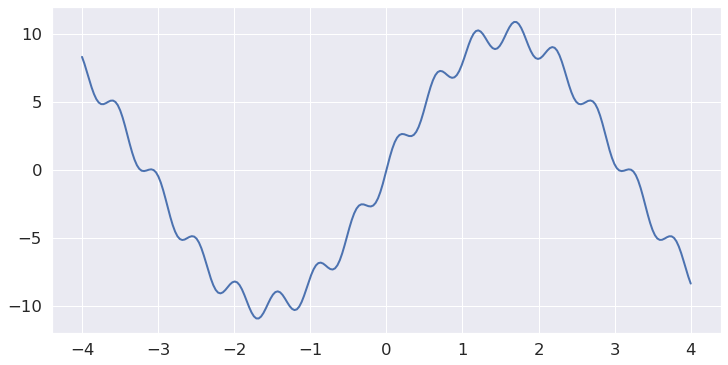

In [4]:
plt.figure(figsize=(12,6))
plt.plot(x, f, linewidth=2)

Сгенерируем оператор, который определяется матрицей $A$ ленточного вида.

Такой оператор соответствует как если бы сигнал обработали moving average, т.е. производит усреднение по некоторому скользящему окну.

In [5]:
A = np.eye(N)
for k in range(1, 15):
    A += np.diag(np.ones(N), k=k)[:N, :N]
    A += np.diag(np.ones(N), k=-k)[:N, :N]

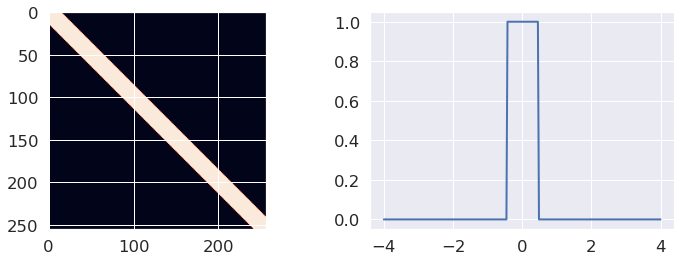

In [6]:
fig, axs = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
axs[0].imshow(A)
axs[1].plot(x, A[N // 2,:], linewidth=2)

Сгенерируем выборку $\xi$ умножив нашу диагональную матрицу $A$ на наш сигнал $f$.

Т.е. эффективно сгладив сигнал moving average.

In [7]:
sigma = 2
noise = sigma * np.random.randn(N)
xi = np.dot(A, f) + noise

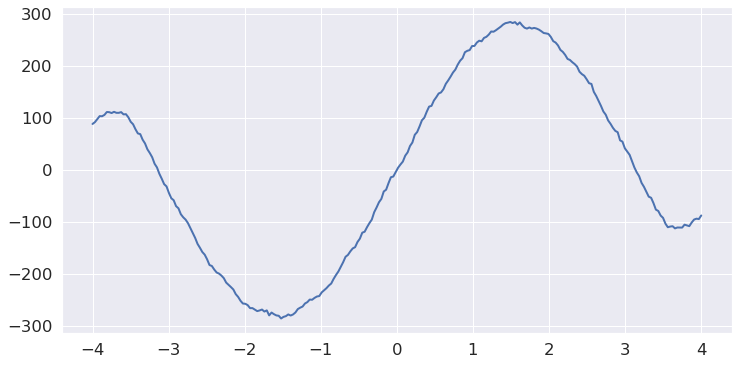

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(x, xi, linewidth=2)

### 1.1 LEAST SQUARES ESTIMATE

Первым делом попробуем восстановить сигнал с помощью LSE, т.е. с помощью метода наименьших квадратов.

$$Af = \xi$$

Матрица псевдорешения(псевдообратная матрица):

$$A^+ = (A^T A)^{-1} A^T$$

Тогда решение можно представить следующим образом:

$$f = A^+ \xi$$

In [9]:
R = np.dot(
        np.linalg.inv(np.dot(A.T, A)),
        A.T
    )
Rxi = np.dot(R, xi)

Text(0.5, 1.0, 'Восстановленный сигнала с помощью LSE')

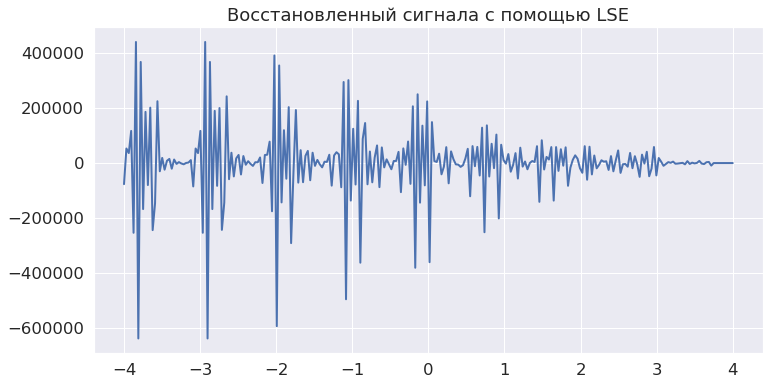

In [10]:
plt.figure(figsize=(12,6))
plt.plot(x, Rxi, linewidth=2)
plt.title('Восстановленный сигнала с помощью LSE')

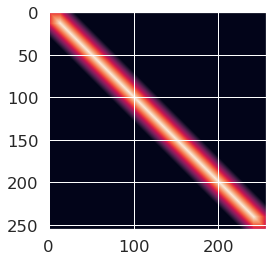

In [11]:
plt.imshow(np.dot(A.T, A))

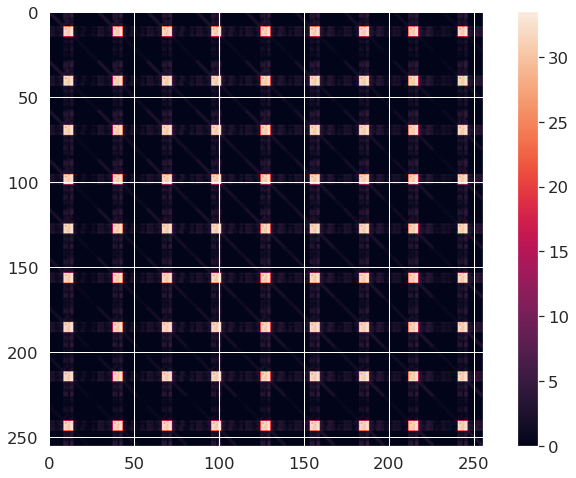

In [12]:
plt.figure(figsize=(12, 8))
plt.imshow(np.log(1. + np.abs(np.linalg.inv(np.dot(A.T, A)))))
plt.colorbar()

## Что произошло?

Наш вариант реализации псевдообратной является неканоничным и страдает из-за плохих собственных значений.
Поэтому лучше использовать специализированные пакеты, которые более эффективно вычисляют псевдообратные матрицы.

https://en.wikipedia.org/wiki/Generalized_inverse

In [15]:
np.linalg.pinv?

$(A + \lambda)^{-1}$

In [16]:
R_pinv = np.linalg.pinv(A)
R_pinv_xi = np.dot(R_pinv, xi)

Text(0.5, 1.0, 'Восстановленный сигнал с помощью np.linalg.pinv')

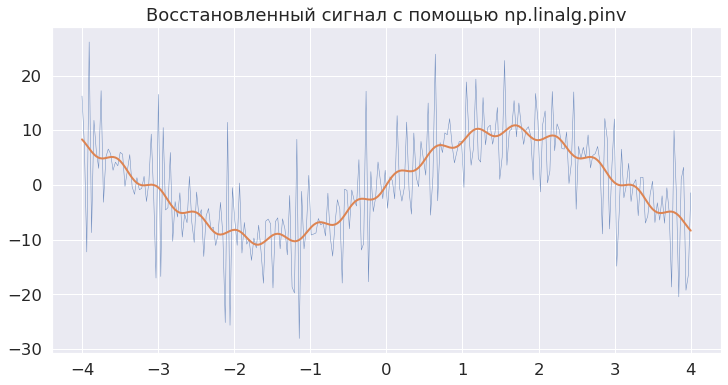

In [17]:
plt.figure(figsize=(12,6))
plt.plot(x, R_pinv_xi, linewidth=0.5, alpha=0.8)
plt.plot(x, f, linewidth=2)
plt.title('Восстановленный сигнал с помощью np.linalg.pinv')

### NOT QUITE THERE YET. REGULARIZE!

In [18]:
c = 1e-3
R_reg = np.dot(
        np.linalg.inv(np.dot(A.T, A) + c * np.eye(N)),
        A.T
    ) 
Rxi_reg = np.dot(R_reg, xi)

Text(0.5, 1.0, 'Восстановленный сигнал при включении регуляризации')

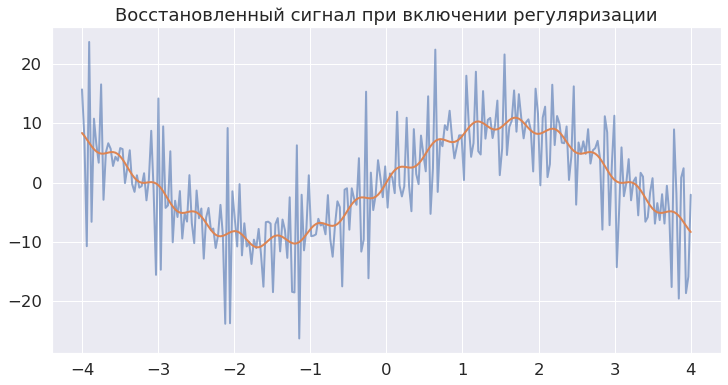

In [19]:
plt.figure(figsize=(12,6))
plt.plot(x, Rxi_reg, linewidth=2, alpha=0.6)
plt.plot(x, f, linewidth=2)
plt.title('Восстановленный сигнал при включении регуляризации')

#### Как выбирать коэффициент регуляризации?

In [20]:
reg_coeffs = np.linspace(0.1, 20, 80)
reg_loss = []
for c in reg_coeffs:
    R_reg = np.dot(
            np.linalg.inv(np.dot(A.T, A) + c * np.eye(N)),
            A.T
        )
    Rxi_reg = np.dot(R_reg, xi)
    loss = np.sum((f - Rxi_reg)**2)
    reg_loss.append(loss)

Text(0.5, 1.0, 'MSE в зависимости от коэффициента регуляризации')

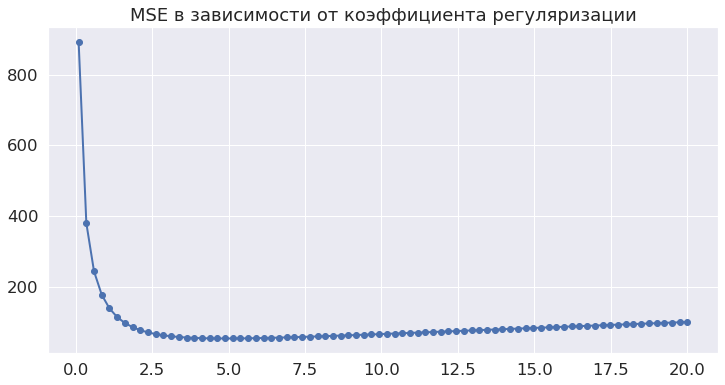

In [21]:
plt.figure(figsize=(12,6))
plt.plot(reg_coeffs, reg_loss, 'o-', linewidth=2)
plt.title('MSE в зависимости от коэффициента регуляризации')

In [22]:
reg_coeffs[np.argmin(reg_loss)]

4.886075949367087

In [23]:
c = 4.886075949367087
R_reg = np.dot(
        np.linalg.inv(np.dot(A.T, A) + c * np.eye(N)),
        A.T
    )
Rxi_reg = np.dot(R_reg, xi)

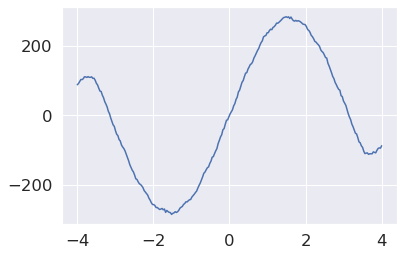

In [25]:
plt.plot(x, xi)

Text(0.5, 1.0, 'Восстановленный сигнал при включении регуляризации')

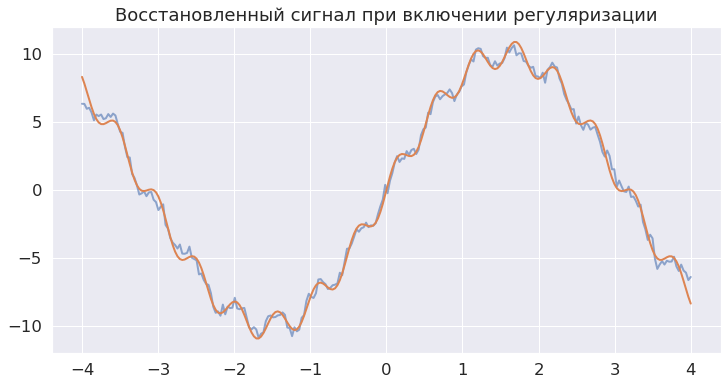

In [26]:
plt.figure(figsize=(12,6))
plt.plot(x, Rxi_reg, linewidth=2, alpha=0.6)
plt.plot(x, f, linewidth=2)
plt.title('Восстановленный сигнал при включении регуляризации')

###  SVD

$$A_{n \times m } = U_{m \times m } \Sigma_{m \times n } V_{n \times n }^T$$


![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bb/Singular-Value-Decomposition.svg/1024px-Singular-Value-Decomposition.svg.png)

In [27]:
U, S, V = np.linalg.svd(A) # V == V^T

In [28]:
(U @ np.diag(S) @ V - A).sum()

2.048193609624386e-12

Text(0.5, 1.0, 'Собственные числа оператора A')

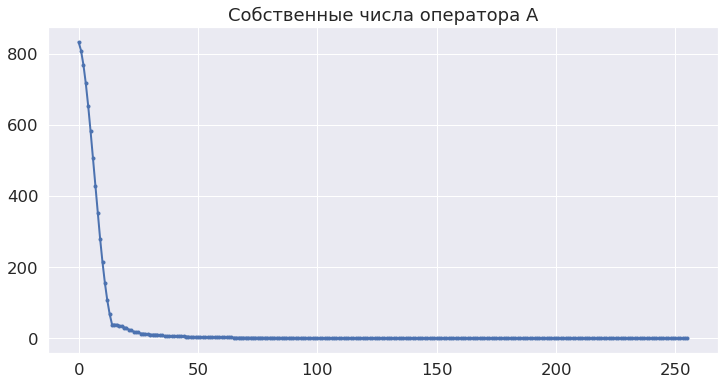

In [34]:
plt.figure(figsize=(12,6))
plt.plot(S**2, '.-', linewidth=2)
plt.title('Собственные числа оператора A')

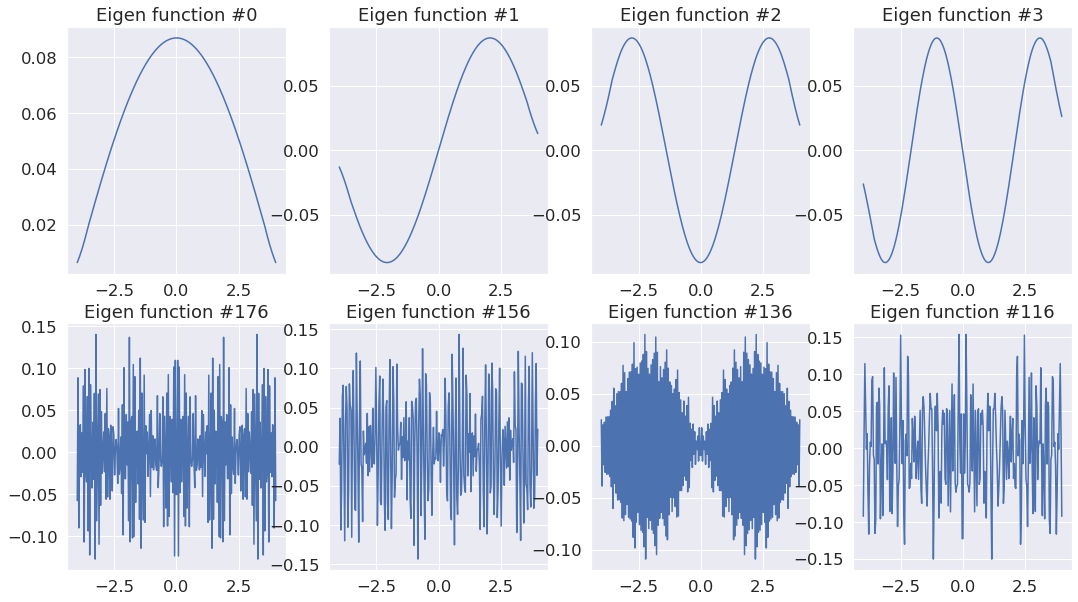

In [35]:
fig, axs = plt.subplots(figsize=(18, 10), ncols=4, nrows=2)
for i in range(4):
    axs[0, i].plot(x, V[i])
    axs[0, i].set_title('Eigen function #{}'.format(i))
for i in range(4):
    axs[1, i].plot(x, V[N -( 4 + i) * 20])
    axs[1, i].set_title('Eigen function #{}'.format(N-(4 + i) * 20))

###### Какая красота :)

Собственные функции очень похожи на функции Фурье. На самом деле за этими функциями лежит серьёзная математика, которая обобщается парой терминов.

https://ee.stanford.edu/~gray/toeplitz.pdf

Цитата из Вики:

```
Матрицы Тёплица также связаны с рядами Фурье, потому что оператор умножения на многочлен из синусов или косинусов, спроецированный на конечномерное пространство, можно представить такой матрицей. 
```

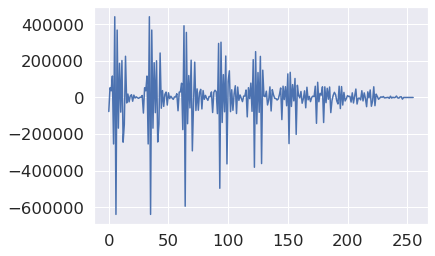

In [36]:
plt.plot(Rxi)

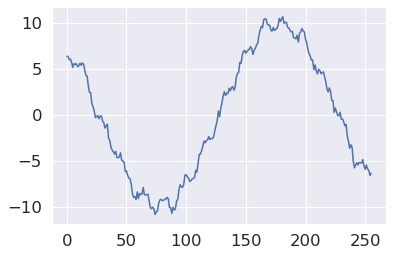

In [37]:
plt.plot(Rxi_reg)

Text(0.5, 1.0, 'Веса ассоциированные с базисными векторами')

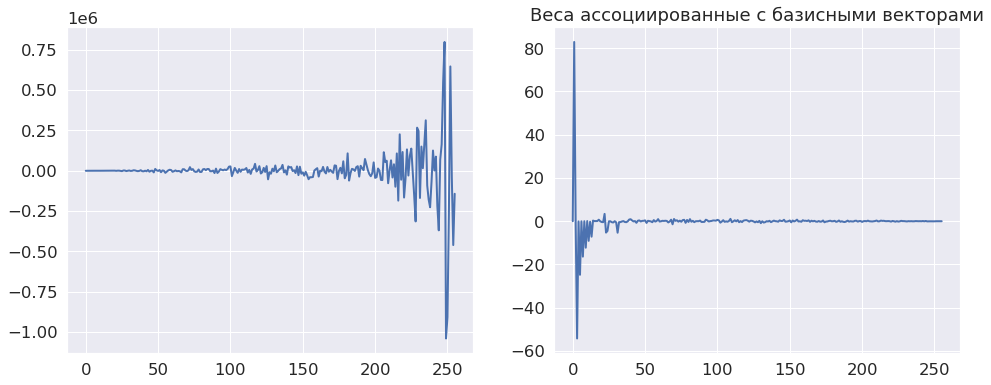

In [39]:
# Отфильтрованный интервал в базисе оператора
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)
axs[0].plot((V * Rxi).sum(axis=1), linewidth=2) 
axs[1].plot((V * Rxi_reg).sum(axis=1), linewidth=2) 
plt.title("Веса ассоциированные с базисными векторами")

### Переходим к базису оператора A и сделаем все те же самые трюки что делали раньше

Как перейти к базису оператора A имея матрицы $U$, $V$ и $S$?

$$\xi = A f + \epsilon$$

$$f_V = V^T f$$

`Note: scipy нам сразу выдал V^T, поэтому мы не транспонируем ещё раз`

In [44]:
f_wave = np.dot(V, f)
noise_wave = noise

In [45]:
A_wave = np.diag(S)

In [46]:
xi_wave = np.dot(A_wave, f_wave) + noise_wave

Text(0.5, 1.0, 'Отфильтрованный сигнал при переходе ')

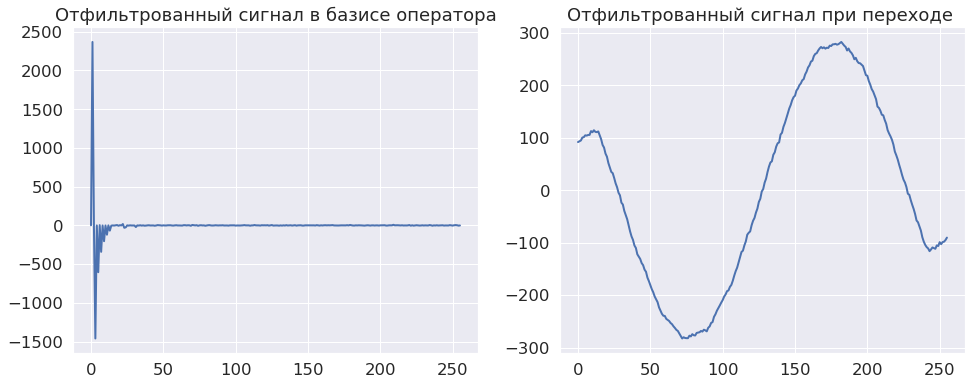

In [47]:
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)

axs[0].plot(xi_wave, linewidth=2)
axs[0].set_title('Отфильтрованный сигнал в базисе оператора')

# Теперь у нас есть xi_wave -- сигнал в базисе оператора A
# покажем, что это тот самый отфильтрованный сигнал, перейдя обратно в изначальный базис
axs[1].plot(np.dot(V.T, xi_wave), linewidth=2) 
axs[1].set_title('Отфильтрованный сигнал при переходе ')

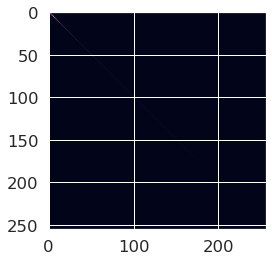

In [50]:
plt.imshow(A_wave)

In [133]:
R_wave = np.dot(
        np.linalg.inv(np.dot(A_wave.T, A_wave)),
        A_wave.T
)
R_wave[:, 50:] = 0
# R_wave[40:, :] = 0
R_wave_xi = np.dot(R_wave, xi_wave)

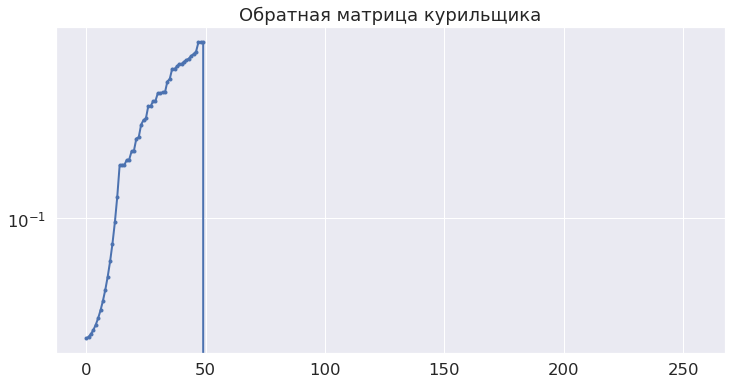

In [134]:
plt.figure(figsize=(12,6))
plt.plot(np.diag(R_wave), '.-', linewidth=2)
plt.title('Обратная матрица курильщика')
plt.yscale('log')

Text(0.5, 1.0, 'Восстановленный сигнал')

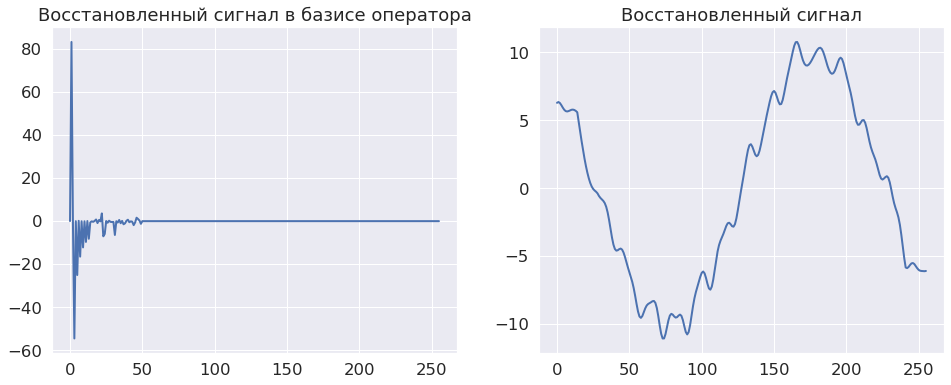

In [135]:
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)
axs[0].plot(R_wave_xi, linewidth=2)
axs[0].set_title('Восстановленный сигнал в базисе оператора')

axs[1].plot(np.dot(V.T, R_wave_xi), linewidth=2)
axs[1].set_title('Восстановленный сигнал')

In [82]:
R_pinv_wave = np.linalg.pinv(A_wave)
R_pinv_wave_xi = np.dot(R_pinv_wave, xi_wave)

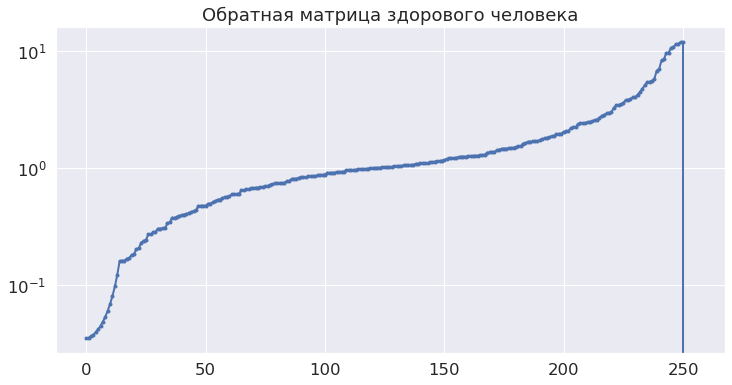

In [58]:
plt.figure(figsize=(12,6))
plt.plot(np.diag(R_pinv_wave), '.-', linewidth=2)
plt.title('Обратная матрица здорового человека')
plt.yscale('log')

Text(0.5, 1.0, 'Восстановленный сигнал')

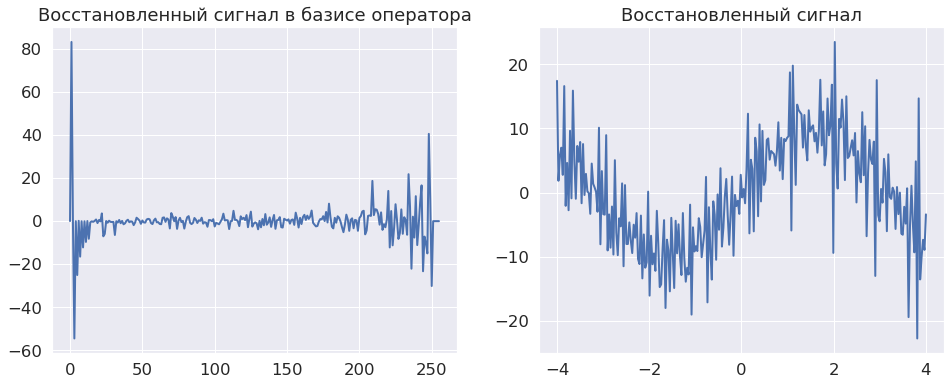

In [59]:
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)
axs[0].plot(R_pinv_wave_xi, linewidth=2)
axs[0].set_title('Восстановленный сигнал в базисе оператора')

axs[1].plot(x, np.dot(V.T, R_pinv_wave_xi), linewidth=2)
axs[1].set_title('Восстановленный сигнал')

In [60]:
c = 4.88
R_wave_reg = np.dot(
        np.linalg.inv(np.dot(A_wave.T, A_wave) + c * np.eye(N)),
        A_wave.T
    )
R_wave_xi_reg = np.dot(R_wave_reg, xi_wave)

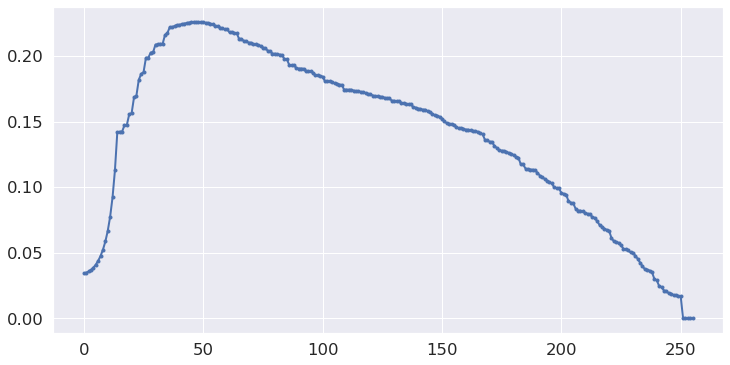

In [61]:
plt.figure(figsize=(12, 6))
plt.plot(np.diag(R_wave_reg), '.-', linewidth=2)

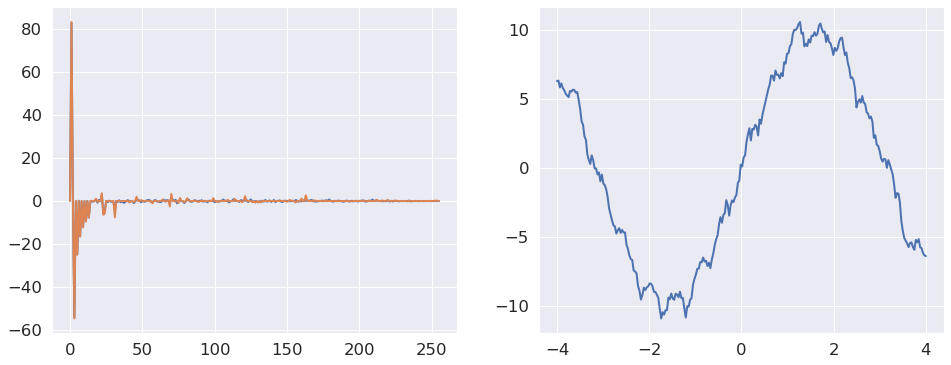

In [62]:
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)
axs[0].plot(R_wave_xi_reg, linewidth=2)
axs[0].plot(f_wave, linewidth=2)
axs[1].plot(x, np.dot(V.T, R_wave_xi_reg), linewidth=2)

# 2. Ridge regression
From: https://jbhender.github.io/Stats506/F17/Projects/G13/Python.html#selecting_labmda_

Ridge regression method is one of the so-called “shrinkage methods”, which is usually applied to a regression model when there is instablity resulting from collinearity of predictors.

In ordinary linear regression (OLS), the estimates of coefficient $\beta$ are given by:
$$\hat\beta=(X^TX)^{-1}X^Ty$$

When the predictors are collinear or almost collinear, the matrix $X^TX$ here becomes singular (rarely the case) or almost singular, then the inverse would respond sensitively to errors, which results in instability of prediction with such a model.

Ridge regression, however, make a trade-off between bias and variance in prediction. By introducing a relatively small bias, you may expect a large reduction in the variance, and thus in the mean-squared error:
$$
MSE=E(\hat\beta-\beta)^2=(E(\hat\beta-\beta))^2+E(\hat\beta-E\hat\beta)^2=\mathrm{bias^2+variance}.
$$
This is achieved by introducing a penalty term into the loss function:
$$
(y-X\beta)^T(y-X\beta)+\lambda\sum_j\beta_j^2.
$$
The $\beta$ that minimizes the new loss function is the ridge regression estimate of $\beta$:
$$
\hat\beta=(X^TX+\lambda I)^{-1}X^Ty.
$$
It is clearly biased as $E(\hat\beta)=(X^TX+\lambda I)^{-1}(X^TX)\beta$ (shrinking the coefficients towards 0), but note that $(X^TX)^{-1}$ is replaced by $(X^TX+\lambda I)^{-1}$ here, which should be less unstable.

In [98]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import csv
import numpy as np
import pandas as pd
from patsy import dmatrices

In [99]:
### Import Data
df = pd.read_csv('seatpos.csv')

### scale the data to have mean 0 stdev 1
df_scaled = preprocessing.scale(df)
df_scaled = pd.DataFrame(df_scaled)

### list of predictors for legend
predictors = list(df.columns.values)[1:9]

### make response (ys) and predictors (xs)
xs = df_scaled.iloc[:, 1:9]
ys = df_scaled.iloc[:, 9]

In [100]:
df.columns

Index(['Unnamed: 0', 'Age', 'Weight', 'HtShoes', 'Ht', 'Seated', 'Arm',
       'Thigh', 'Leg', 'hipcenter'],
      dtype='object')

## Variance Inflation Factor (VIF) Calculation

Ridge regression is to slove the problems in the regression caused by multicollinearity. We have to check for multicollinearity first. In this page, we check for high variance inflation factors (VIFs). The rule of thumb is that a VIF>10 indicates multicollinearity. In Python we can use the statsmodels.stats.outliers_infuence package to calculate VIF of a multiple regression output (made by dmatrices package).

In [101]:
######### VIF Calculations
### Run multiple regression
features="+".join(set(df.columns) - set(["hipcenter"]))
y,X = dmatrices('hipcenter ~' + features, df, return_type='dataframe')

### Calculate VIF Factors
vif=pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif["features"] = X.columns

print(vif.round(1))

   VIF Factor   features
0       741.0  Intercept
1         3.6     Weight
2         6.7        Leg
3       333.1         Ht
4         9.0     Seated
5       307.4    HtShoes
6         4.5        Arm
7         2.8      Thigh
8         2.0        Age


In [105]:
regression = ElasticNet # Ridge # Lasso # Ridge
# \sum |w_i|

In [103]:
ElasticNet?

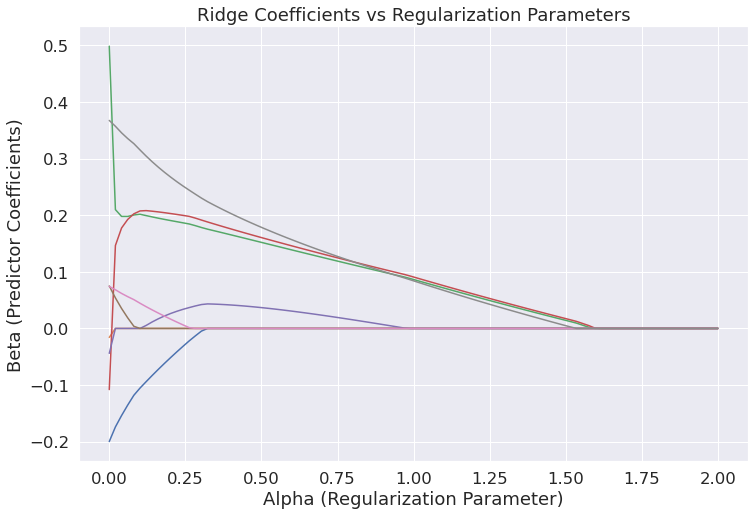

In [106]:
###initialize list to store coefficient values
coef = []
alphas = np.linspace(0, 2, 100)

for a in alphas:
    ridgereg = regression(alpha=a, l1_ratio)
    ridgereg.fit(xs,ys)
    coef.append(ridgereg.coef_)

### Make plot of Beta as a function of Alpha
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(alphas,coef)
ax.set_xlabel('Alpha (Regularization Parameter)')
ax.set_ylabel('Beta (Predictor Coefficients)')
ax.set_title('Ridge Coefficients vs Regularization Parameters')
ax.axis('tight')
fig.savefig('coef_vs_alpha.png')

In [107]:
###Selecting lambda
scaler = StandardScaler()
X_std = scaler.fit_transform(xs)

###Fit Ridge regression through cross validation
regr_cv = RidgeCV(alphas=range(1, 40))
model_cv = regr_cv.fit(X_std, ys)

print(model_cv.alpha_)

22


# 3. AIC, BIC, CV и bias-variance decomposition


## AIC
 

$$\text{AIC} = −2 \log(L(\theta|\mathrm{data})) + 2K$$

Для LR:

$$\text{AIC} = n \log(\text{RSS}/n) + 2K,$$

где $n$ -- количество объектов в выборке, $K$ -- количество параметров модели.



__Интересный факт:__

AIC асимптотически эквивалентен $Leave-One-Out$ кросс-валидации для любой модели машинного обучения.

[AIC can be shown to be equivalent to leave-one-out cross-validation](http://www.jstor.org/stable/2984877).



## BIC


$$\text{BIC} = −2 \log(L(\theta|\mathrm{data})) + \log(n) K$$

__Интересный факт:__

BIC для линейной модели асимптотически эквивалентен $Leave-v-Out$ кросс-валидации, где $v=n\left[ 1 - \frac{1}{\log{(n)}  - 1} \right]$.


### Как выбирать между AIC и BIC?

Есть ещё один вывод, который можно сделать из работы Shao. BIC выбирает с большей вероятностью верную модель, если такая есть. Но это очень сильное утверждение, что среди набора моделей, которая является верной, т.е. описывает данные. 

С другой стороны, AIC чаще выбирает модель, которая показывает более хороший результат. 

## Mallow's $C_p$ Statistic


$$C_p = MSE + \frac{2}{\hat{\sigma}^2} n K$$

In [108]:
import statsmodels.api as sm

In [112]:
from sklearn.model_selection import train_test_split
N = 250

x = np.linspace(-6, 6, N)
X = np.vstack([
    x, 
    np.random.randn(N) / 10,
    np.random.randn(N) / 10,
    np.random.randn(N) / 10,
    np.random.randn(N) / 10,
]).T
Y = 5 + 2 * x + x**2 - 2 * x**3 + np.random.randn(*x.shape)

X_train, X_test, Y_train, Y_test = X[:len(X) // 2], X[len(X) // 2:], Y[:len(X) // 2], Y[len(X) // 2:]

In [113]:
res = sm.OLS(Y_train, X_train).fit()

In [114]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.863
Model:                            OLS   Adj. R-squared (uncentered):              0.857
Method:                 Least Squares   F-statistic:                              151.0
Date:                Mon, 17 May 2021   Prob (F-statistic):                    4.93e-50
Time:                        16:12:01   Log-Likelihood:                         -701.12
No. Observations:                 125   AIC:                                      1412.
Df Residuals:                     120   BIC:                                      1426.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -46.9062      1.759    -26.672      0.000     -50.388     -43.424
x2           107.4101     70.691      1.519      0.131     -32.554     247.374
x3          -157.5644     64.233     -2.453      0.016    -284.741     -30.388
x4            39.2492     64.573      0.608      0.544     -88.600     167.098
x5            60.8446     62.767      0.969      0.334     -63.431     185.120
==============================================================================
Omnibus:                       30.334   Durbin-Watson:                   0.110
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.605
Skew:                           1.325   Prob(JB):                     5.60e-10
Kurtosis:                       4.077   Cond. No.                         43.2
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [116]:
X_train.shape

(125, 5)

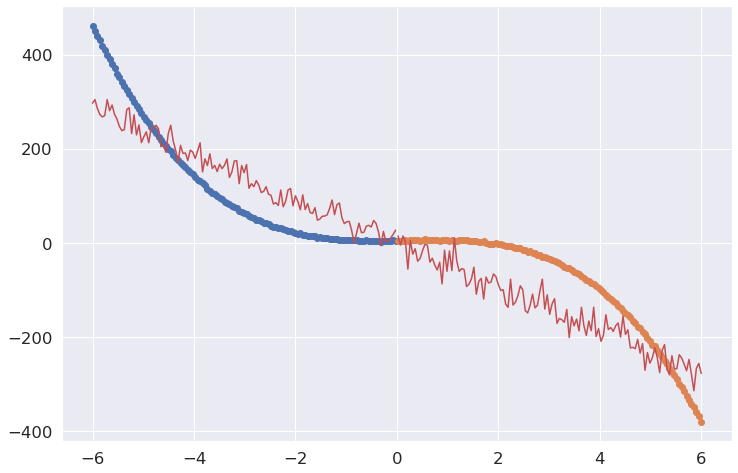

In [115]:
plt.figure(figsize=(12, 8))
plt.scatter(X_train[:, 0], Y_train)
plt.plot(X_train[:, 0], res.predict(X_train), c='r')


plt.scatter(X_test[:, 0], Y_test)
plt.plot(X_test[:, 0], res.predict(X_test), c='r')
plt.show()

In [128]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=4).fit(X)
X_train_poly = poly.transform(X_train)

In [129]:
X_train_poly.shape

(125, 126)

In [130]:
res = sm.OLS(Y_train, X_train_poly).fit()

In [131]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 17 May 2021   Prob (F-statistic):                nan
Time:                        16:14:58   Log-Likelihood:                 2681.9
No. Observations:                 125   AIC:                            -5114.
Df Residuals:                       0   BIC:                            -4760.
Df Model:                         124                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.8434        inf         -0        nan         nan         nan
x1           -14.4684        inf         -0        nan         nan         nan
x2             7.8662        inf          0        nan         nan         nan
x3           -73.2729        inf         -0        nan         nan         nan
x4            55.6231        inf          0        nan         nan         nan
x5            39.7628        inf          0        nan         nan         nan
x6            -8.3282        inf         -0        nan         nan         nan
x7           -40.3255        inf         -0        nan         nan         nan
x8           -60.4481        inf         -0        nan         nan         nan
x9           110.6343        inf          0        nan         nan         nan
x10            9.5552        inf          0        nan         nan         nan
x11         -601.7071        inf         -0        nan         nan         nan
x12        -2175.3149        inf         -0        nan         nan         nan
x13         1143.0698        inf          0        nan         nan         nan
x14         2045.2583        inf          0        nan         nan         nan
x15          886.7161        inf          0        nan         nan         nan
x16         1095.9950        inf          0        nan         nan         nan
x17         -615.5126        inf         -0        nan         nan         nan
x18          911.9216        inf          0        nan         nan         nan
x19         -319.9383        inf         -0        nan         nan         nan
x20         1011.7909        inf          0        nan         nan         nan
x21           -4.2852        inf         -0        nan         nan         nan
x22          -13.2569        inf         -0        nan         nan         nan
x23          -17.5098        inf         -0        nan         nan         nan
x24           47.0440        inf          0        nan         nan         nan
x25            1.3834        inf          0        nan         nan         nan
x26          198.7172        inf          0        nan         nan         nan
x27         -615.8912        inf         -0        nan         nan         nan
x28          166.7495        inf          0        nan         nan         nan
x29         1486.5827        inf          0        nan         nan         nan
x30          827.5378        inf          0        nan         nan         nan
x31          -36.7243        inf         -0        nan         nan         nan
x32         -158.2613        inf         -0        nan         nan         nan
x33          257.6923        inf          0        nan         nan         nan
x34          731.9427        inf          0        nan         nan         nan
x35          343.8299        inf          0        nan         nan         nan
x3

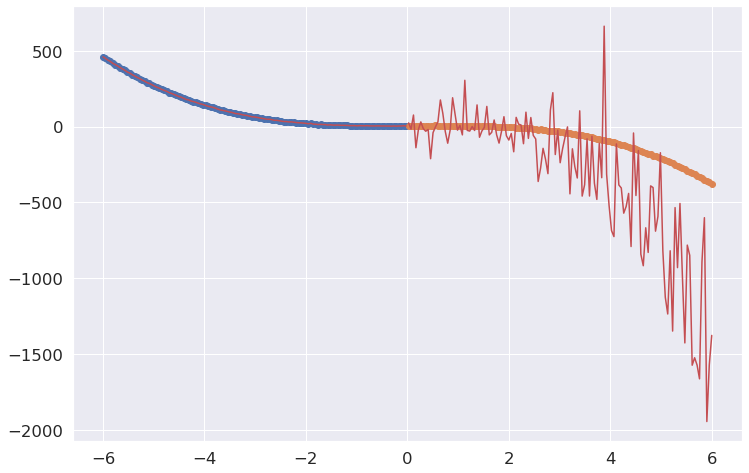

In [132]:
plt.figure(figsize=(12, 8))
plt.scatter(X_train[:, 0], Y_train)
plt.plot(X_train[:, 0], res.predict(X_train_poly), c='r')


plt.scatter(X_test[:, 0], Y_test)
plt.plot(X_test[:, 0], res.predict(poly.transform(X_test)), c='r')
# plt.xlim(-5, 0)
# plt.ylim(0, 20)
plt.show()

# RVM

### Relevance Vector Machine

Метод релевантных векторов -- линейная регрессия под амфетамином с дисперсиями и байесовскими методами.

Задача ставится классическим образом: построить модель зависимости для выборки вида $(X, y) = \{ x_i, y_i \}_{i=1}^N$. Причём мы

$$f(x_i) = w^T x_i$$

#### Вероятностная интерпретация линейной регрессии

$$p(y|X, w) = \prod\limits_{i=1}^{N} p(t_i|x_i, w) = \prod\limits_{i=1}^{N} \mathcal{N}(y_i | w^T x_i, \sigma^2) =$$

$$= \frac{1}{\sigma^n (2 \pi)^{n/2}} \exp \left( - \frac{\sum\limits_{i=1}^{N} (y_i - w^T x_i)^2}{2 \sigma^2} \right)$$

Переходим к лагорифму:

$$\log p(y|X, w) = -\frac{1}{2\sigma^2}\sum\limits_{i=1}^{N}\left(y_i - w^T x_i\right)^2 \rightarrow \max_{w}$$



#### Добавление регуляризации с точки зрения байесовских методов

$$p(y|X, w) = \prod\limits_{i=1}^{N} p(t_i|x_i, w) p(w), ~~~ p(w) = \mathcal{N}(w | 0, \alpha^{-1})$$


$$-\frac{1}{2\sigma^2}\sum\limits_{i=1}^{N}\left(y_i - w^T x_i\right)^2 - \frac{\alpha}{2} ||w||_2^2 \rightarrow \max_{w}$$

Другими словами, l2-регуляризация эквивалентна тому что мы вешаем на веса априорную плотность.



Минусы: \sigma^2$ и $\alpha$ одни для всех признаков и фиксированы(нужна кросс-валидация);

### RVR...
...или почему бы нам не добавить распределение на параметры распределения параметров распределения?

$$p(w|\alpha) = \mathcal{N}(0, A^{-1}),~~~A=\mathrm{diag}(\alpha_1, \dots, \alpha_m)$$

Тогда используя сложную математику(см. [1]) можно придумать как обучать такую модель где для каждого признака будет своя собственная дисперсия, которая подбирается автоматически.

[1] http://www.machinelearning.ru/wiki/images/4/43/BayesML-2007-textbook-2.pdf

[2] http://www.machinelearning.ru/wiki/index.php?title=RVM